# Customer Churn Prediction for Banking Service

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

import joblib
import pickle

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 1. Load and Explore the Dataset

In [2]:
df = pd.read_csv('Churn_Modelling.csv')
print("Dataset shape: ", df.shape)
print('ramdom 5 rows:')
df.sample(5)

Dataset shape:  (10000, 14)
ramdom 5 rows:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1475,1476,15745080,Griffiths,634,France,Male,26,8,0.00,1,1,0,21760.96,0
5760,5761,15785350,Austin,528,Spain,Male,23,7,104744.89,1,1,0,170262.97,0
323,324,15585215,Yuan,763,France,Female,31,4,0.00,2,0,0,50404.72,0
4279,4280,15781777,Sutherland,604,France,Male,33,3,148659.48,1,0,0,42437.75,0
7023,7024,15605791,Li,524,Germany,Male,29,9,144287.60,2,1,0,32063.30,0


In [3]:
print("Dataset Info: ")
df.info()
print()
print('Basic Statestics: ')
df.describe()

Dataset Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB

Basic Statestics: 


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [4]:
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [5]:
print("Column Names: \n", df.columns.tolist())

Column Names: 
 ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


# 2. Data Cleaning

In [6]:
# Drop unwanted columns
df_cleaned = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis =1)
# check cleaned dataset
df_cleaned.sample(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
3636,663,Spain,Male,31,4,103430.11,2,0,1,36479.27,0
6796,651,France,Female,25,8,0.00,2,1,1,126761.20,0
643,660,Germany,Female,39,5,135134.99,1,1,0,173683.00,1
396,557,France,Male,33,3,54503.55,1,1,1,371.05,0
480,788,Spain,Male,34,6,156478.62,1,0,1,181196.76,0


In [7]:
# checking missing values in cleanded dataset
df_cleaned.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [8]:
# check datatype
df_cleaned.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [9]:
# check unique values for categorical columns
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_cols.tolist())
for col in categorical_cols:
    print(f"\n {col}: {df_cleaned[col].unique()}")
    print(f"Value counts: \n {df_cleaned[col].value_counts()}")

Categorical columns: ['Geography', 'Gender']

 Geography: ['France' 'Spain' 'Germany']
Value counts: 
 Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

 Gender: ['Female' 'Male']
Value counts: 
 Gender
Male      5457
Female    4543
Name: count, dtype: int64


In [10]:
# Check the target variable distribution 
print("Target variable distribution: ")
print(df_cleaned["Exited"].value_counts())
print(f"\nChurn Rate: {df_cleaned['Exited'].mean(): .2%}")

Target variable distribution: 
Exited
0    7963
1    2037
Name: count, dtype: int64

Churn Rate:  20.37%


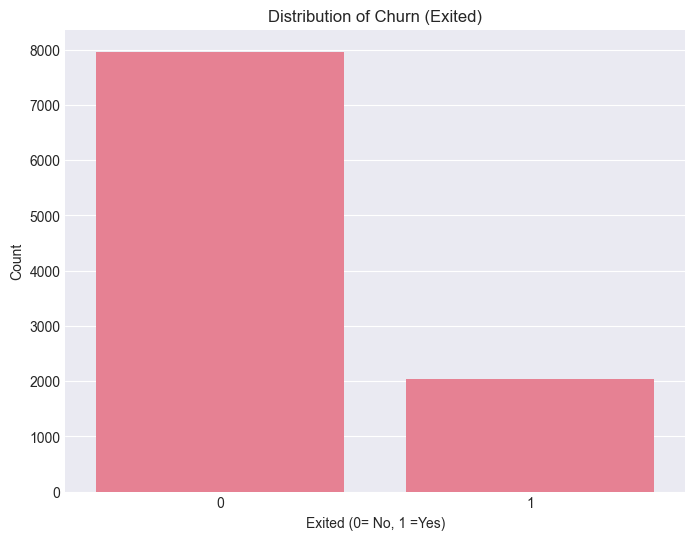

In [11]:
# Visualize the target variable
plt.figure(figsize =(8,6))
sns.countplot(data= df_cleaned, x= 'Exited')
plt.title('Distribution of Churn (Exited)')
plt.xlabel('Exited (0= No, 1 =Yes)')
plt.ylabel('Count')
plt.show()

# 3. Exploratory Data Analysis (EDA)

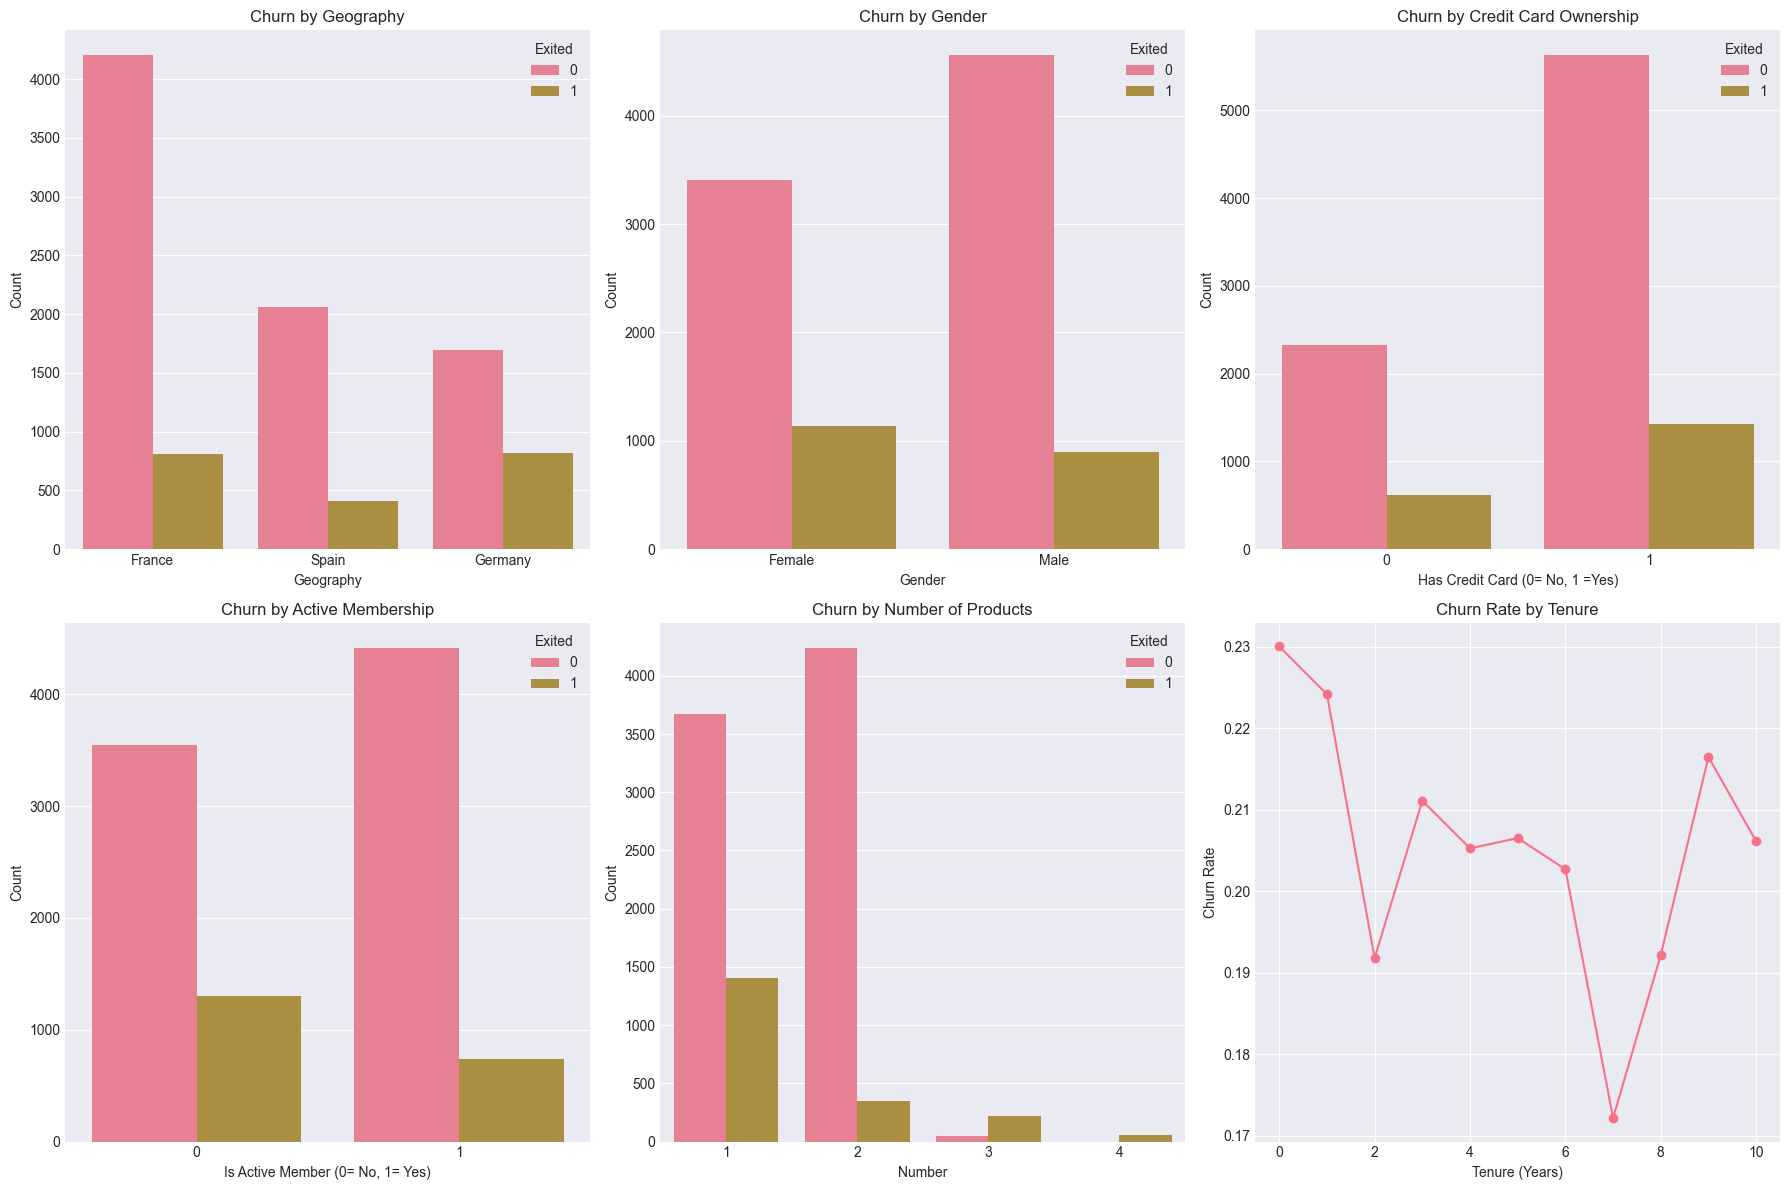

In [12]:
fig, axes = plt.subplots(2,3, figsize =(18, 12))
# 1. geography vs Churn
sns.countplot(data= df_cleaned, x= 'Geography', hue = 'Exited', ax = axes[0,0])
axes[0,0].set_title('Churn by Geography')
axes[0,0].set_xlabel('Geography')
axes[0,0].set_ylabel('Count')

# 2. Gender vs Churn
sns.countplot(data = df_cleaned, x= 'Gender', hue = 'Exited', ax= axes[0,1])
axes[0,1].set_title('Churn by Gender')
axes[0,1].set_xlabel('Gender')
axes[0,1].set_ylabel('Count')

# 3. HasCrCard vs Churn
sns.countplot(data= df_cleaned, x= 'HasCrCard', hue = 'Exited', ax= axes[0,2])
axes[0,2].set_title('Churn by Credit Card Ownership')
axes[0,2].set_xlabel('Has Credit Card (0= No, 1 =Yes)')
axes[0,2].set_ylabel('Count')

# 4. IsActiveMember vs Churn
sns.countplot(data= df_cleaned, x = 'IsActiveMember', hue='Exited', ax= axes[1,0])
axes[1,0].set_title('Churn by Active Membership')
axes[1,0].set_xlabel('Is Active Member (0= No, 1= Yes)')
axes[1,0].set_ylabel('Count')

# 5. NumOfProducts vs Churn
sns.countplot(data= df_cleaned, x = 'NumOfProducts', hue = 'Exited', ax= axes[1,1])
axes[1,1].set_title('Churn by Number of Products')
axes[1,1].set_xlabel('Number')
axes[1,1].set_ylabel('Count')

# 6. Tenure vs Churn
df_cleaned.groupby('Tenure')['Exited'].mean().plot(kind = 'line', ax = axes[1,2], marker= 'o')
axes[1,2].set_title('Churn Rate by Tenure')
axes[1,2].set_xlabel('Tenure (Years)')
axes[1,2].set_ylabel('Churn Rate')

plt.tight_layout()
plt.show()

# Numerical features analysis

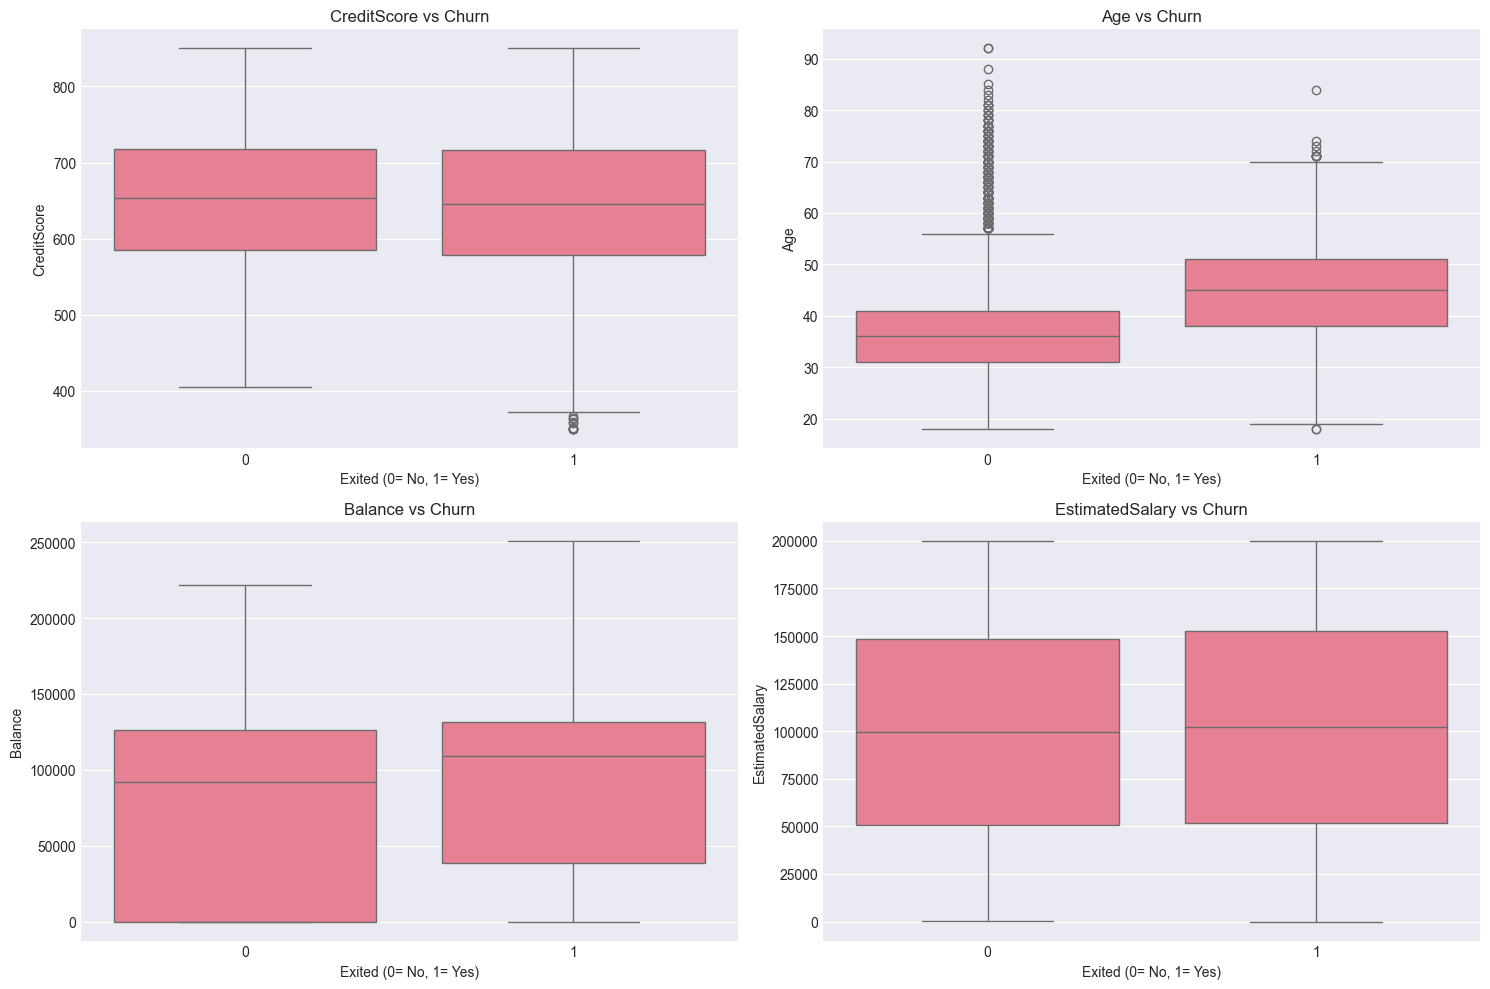

In [13]:
numerical_cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
fig, axes= plt.subplots(2,2, figsize= (15,10))
for idx, col in enumerate(numerical_cols):
    row, col_idx= idx // 2, idx %2
    sns.boxplot(data = df_cleaned, x= 'Exited', y = col, ax= axes[row, col_idx])
    axes[row, col_idx].set_title(f'{col} vs Churn')
    axes[row, col_idx].set_xlabel('Exited (0= No, 1= Yes)')
    axes[row, col_idx].set_ylabel(col)

plt.tight_layout()
plt.show()

# Correlation matrix

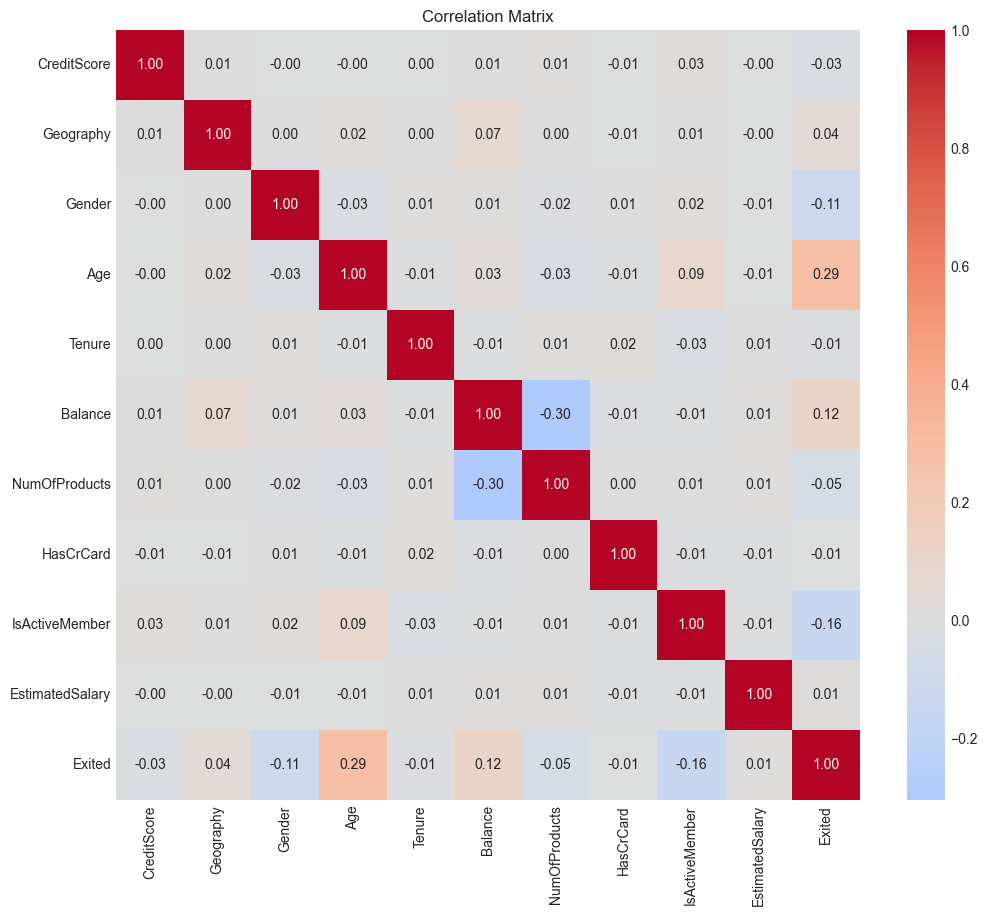

In [14]:
plt.figure(figsize= (12,10))
# Encode categorical variables for correlation analysis
df_encoded = df_cleaned.copy()
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

corr_matrix = df_encoded.corr()
sns.heatmap(corr_matrix, annot= True, fmt='.2f', cmap= 'coolwarm', center = 0)
plt.title('Correlation Matrix')
plt.show()

In [15]:
# Display top correlations with target 
print("Top correlations with Exited (Churn): ")
corr_with_target = corr_matrix['Exited'].sort_values(ascending = False)
print(corr_with_target)

Top correlations with Exited (Churn): 
Exited             1.000000
Age                0.285323
Balance            0.118533
Geography          0.035943
EstimatedSalary    0.012097
HasCrCard         -0.007138
Tenure            -0.014001
CreditScore       -0.027094
NumOfProducts     -0.047820
Gender            -0.106512
IsActiveMember    -0.156128
Name: Exited, dtype: float64


# 4. Features Engineering and Preprocessing

In [16]:
# Create a copy for preprocessing
df_processed = df_cleaned.copy()

In [17]:
# Handle categorical variables using one-hot encoding
df_processed = pd.get_dummies(df_processed, columns=['Geography', 'Gender'], drop_first= True)


In [18]:
# Display processed dataset
print("Processed dataset shape:", df_processed.shape)
print("\nProcessed columns: ")
print(df_processed.columns.tolist())


Processed dataset shape: (10000, 12)

Processed columns: 
['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited', 'Geography_Germany', 'Geography_Spain', 'Gender_Male']


# Split features and target

In [19]:
X= df_processed.drop('Exited', axis = 1)
y= df_processed['Exited']
print('Features shape:', X.shape)

Features shape: (10000, 11)


# Split into train and test ssets

In [20]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=  0.2, random_state= 42, stratify =y)

# Scale numerical features

In [21]:
scaler = StandardScaler()
# Identify numerical columns (excluding the encoded ones)
num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

# Fit and transform on training data, transform on test data
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])
print("Scaling completed!")

Scaling completed!


# 5. Handle Class Imbalance

In [22]:
# Check class distribution 
print("Before handling imbalance: ")
print(f"Class 0 (No Churn): {sum(y_train == 0)} samples")
print(f"Class 1 (Churn): {sum(y_train==1)} samples")
print(f"Churn rates: {y_train.mean():.2%}" )

Before handling imbalance: 
Class 0 (No Churn): 6370 samples
Class 1 (Churn): 1630 samples
Churn rates: 20.38%


# Option 1: SMOTE (Synthetic Minority Over-sampling Technique)


In [23]:
smote = SMOTE(random_state= 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("\nAfter SMOTE: ")
print(f" Class 0 (No Churn): {sum(y_train_smote == 0)} samples")

print(f" Class 1 (Churn): {sum(y_train_smote == 1)} samples")


After SMOTE: 
 Class 0 (No Churn): 6370 samples
 Class 1 (Churn): 6370 samples


# 6. Model Building and Training

# Initialize models

In [24]:
models ={
    'Logistic Regression': LogisticRegression(random_state = 42, max_iter = 1000),
    'Decision Tree': DecisionTreeClassifier(random_state= 42),
    'Gradient Boosting': GradientBoostingClassifier(random_state= 42),
    'Random Forest': RandomForestClassifier(random_state= 42, n_jobs=1)
    
}


In [25]:
# Train and evaluate each model
results= {}
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    # Train the model
    if model_name == 'Logistic Regression':
        # Use original data for Logistic Regression (works better without SMOTE sometimes)
        model.fit(X_train_scaled, y_train)
        y_pred= model.predict(X_test_scaled)
        y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # Use SMOTE data for tree-based models
        model.fit(X_train_smote, y_train_smote)
        y_pred = model.predict(X_test_scaled)
        y_pred_prob = model.predict_proba(X_test_scaled)[:,1]


Training Logistic Regression...

Training Decision Tree...

Training Gradient Boosting...

Training Random Forest...


In [26]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

In [27]:
# store results
results[model_name]= {
    'model': model,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'roc_auc': roc_auc,
    'y_pred': roc_auc,
    'y_pred': y_pred,
    'y_pred_prob': y_pred_prob
}

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall: .4f}")
print(f"F1-Score: {f1: .4f}")
print(f"ROC-AUC: {roc_auc: .4f}")

Accuracy: 0.8405
Precision: 0.6140
Recall:  0.5823
F1-Score:  0.5977
ROC-AUC:  0.8453


# 7. Model Comparison and Evaluation

In [28]:
#  Create a comparison DataFrame
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'F1-Score': [results[m]['f1'] for m in results],
    'ROC-AUC': [results[m]['roc_auc'] for m in results]
})
print("Model Performance Comparison:")
print(results_df.sort_values('F1-Score', ascending =False))

Model Performance Comparison:
           Model  Accuracy  Precision   Recall  F1-Score   ROC-AUC
0  Random Forest    0.8405    0.61399  0.58231   0.59773  0.845314


# Visualize model performance

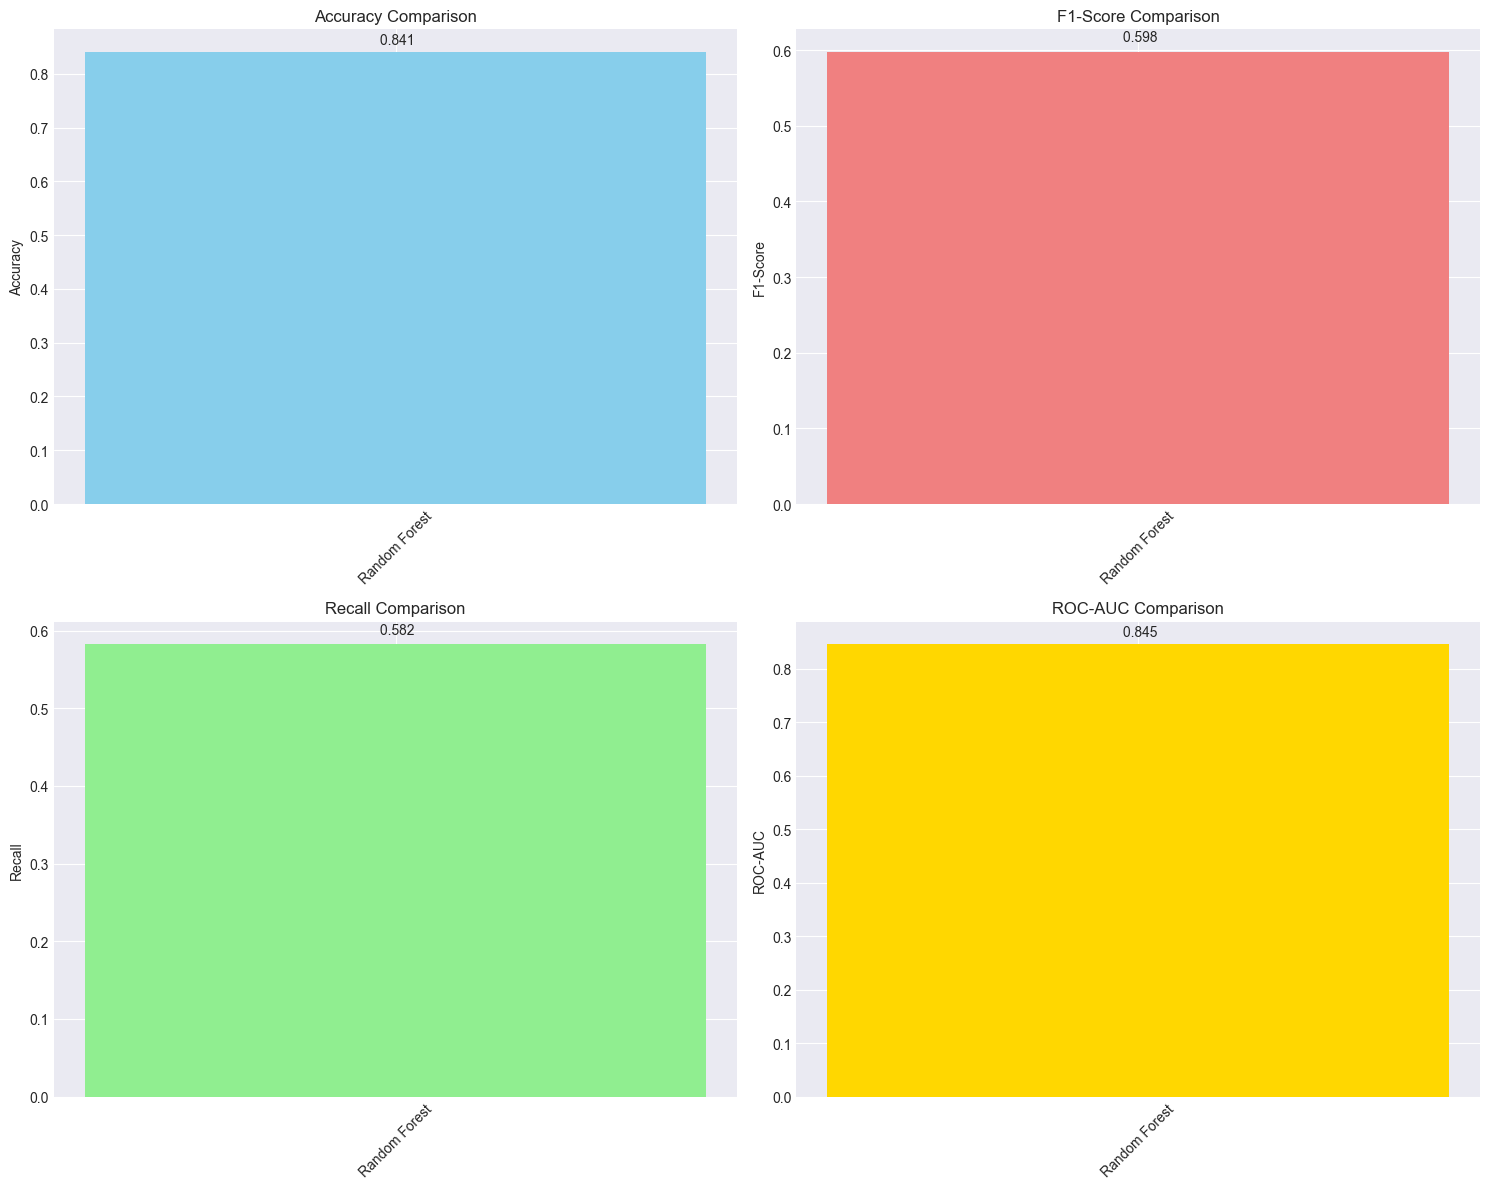

In [29]:
fig, axes = plt.subplots(2,2 , figsize= (15,12))
# 1. Bar chart for accuracy and F1-Score
metrics_to_plot = ['Accuracy', 'F1-Score', 'Recall', 'ROC-AUC']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']
for idx, metric in enumerate(metrics_to_plot):
    row, col = idx//2, idx %2
    axes[row, col].bar(results_df['Model'], results_df[metric], color= colors[idx])
    axes[row, col].set_title(f'{metric} Comparison')
    axes[row, col].set_ylabel(metric)
    axes[row, col].tick_params(axis= 'x', rotation =45)

    # Add value labels on bars
    for i, v in enumerate(results_df[metric]):
        axes[row, col].text(i,v+0.01, f'{v: .3f}', ha= 'center', va= 'bottom')
plt.tight_layout()
plt.show()

# Confusion matrices for all models

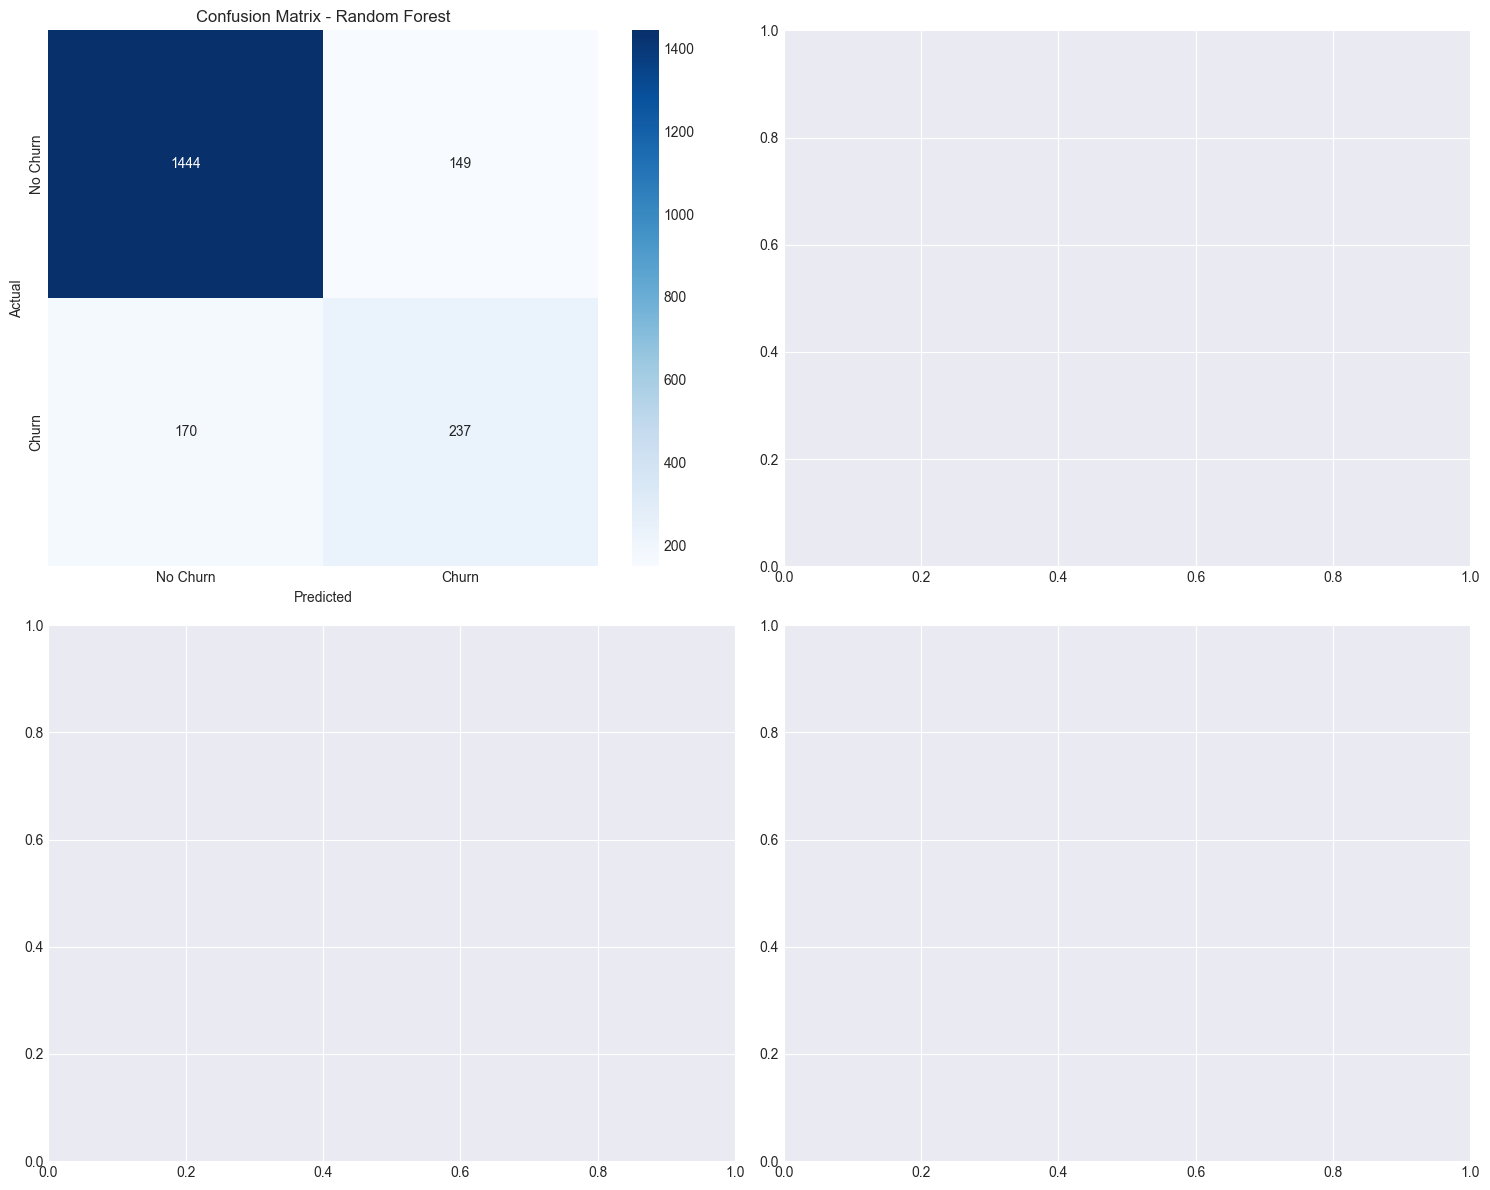

In [30]:
fig, axes = plt.subplots(2,2, figsize=(15,12))
for idx, (model_name, result) in enumerate(results.items()):
    row, col =idx // 2,  idx % 2
    cm= confusion_matrix(y_test, result['y_pred'])
    sns.heatmap(cm, annot = True, fmt='d', cmap= 'Blues', ax= axes[row,col])
    axes[row, col].set_title(f'Confusion Matrix - {model_name}')
    axes[row, col].set_xlabel('Predicted')
    axes[row, col].set_ylabel('Actual')
    axes[row, col].set_xticklabels(['No Churn', 'Churn'])
    axes[row, col].set_yticklabels(['No Churn', 'Churn'])

plt.tight_layout()
plt.show()

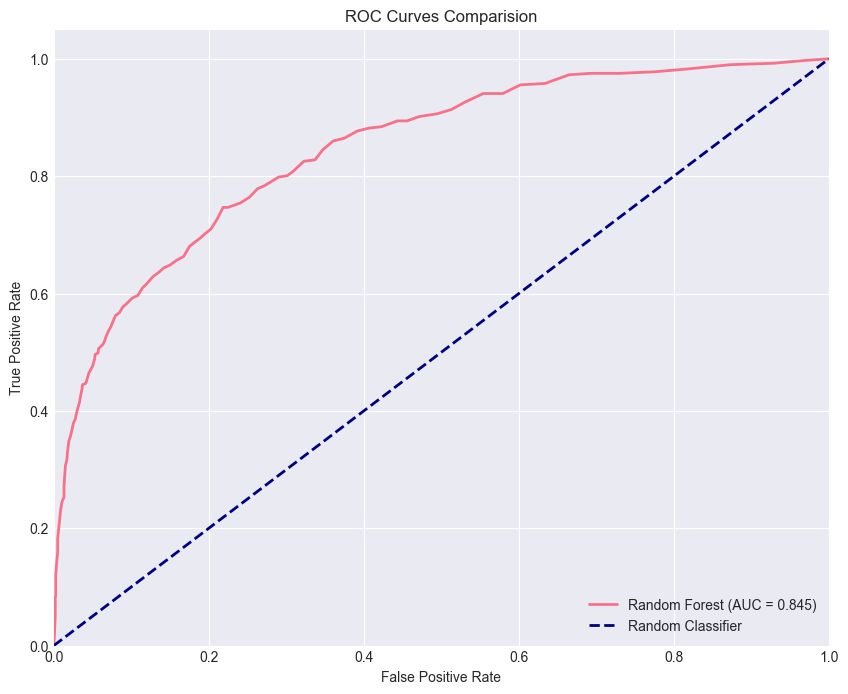

In [31]:
plt.figure(figsize=(10,8))
for model_name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_prob'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label= f'{model_name} (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1], color = 'navy', lw=2, linestyle= '--', label = 'Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparision')
plt.legend(loc = 'lower right')
plt.grid(True)
plt.show()

# 8. Feature Importance Analysis

In [32]:
best_model = results["Random Forest"]['model']
feature_importance = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)
print('Top 10 Most Important Features:')
print(feature_importance.head(10))

Top 10 Most Important Features:
              feature  importance
1                 Age    0.271898
3             Balance    0.123865
4       NumOfProducts    0.123372
7     EstimatedSalary    0.114505
0         CreditScore    0.109205
2              Tenure    0.097908
6      IsActiveMember    0.058568
8   Geography_Germany    0.053024
5           HasCrCard    0.016795
10        Gender_Male    0.016394


# Visualize feature importance

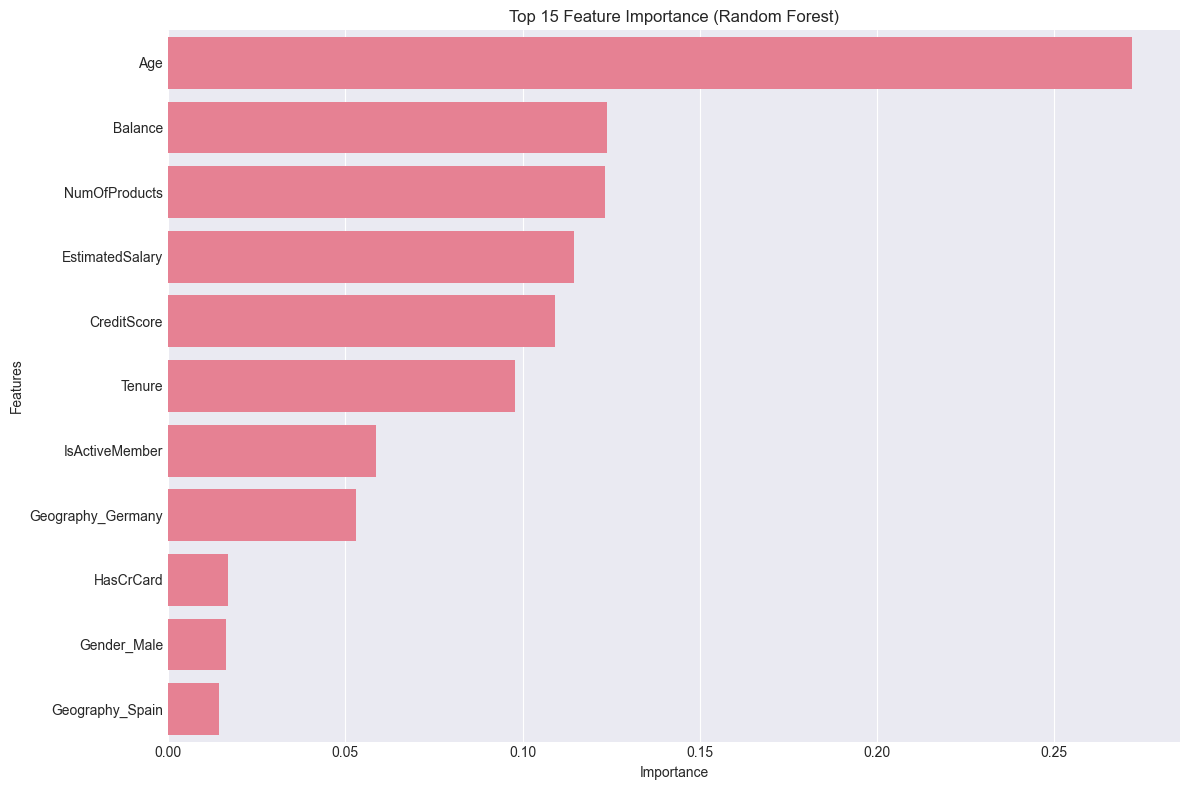

In [33]:
plt.figure(figsize = (12, 8))
sns.barplot(data=feature_importance.head(15), x= 'importance', y ='feature')
plt.title('Top 15 Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# 9. Hyperparameter tuning for bet model

In [34]:
print("Hyperparameter tuning for Random Forest")
# Define parameter grid
param_grid ={
    'n_estimators': [100,200,300],
    'max_depth': [10,20, 30, None],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'max_features':['sqrt','log2']
}
# Initialize grid search 
rf = RandomForestClassifier(random_state = 42, n_jobs =-1)
grid_search = GridSearchCV(
    estimator = rf,
    param_grid = param_grid,
    cv = 3,
    n_jobs = -1,
    verbose = 1,
    scoring = 'f1'
)


Hyperparameter tuning for Random Forest


In [35]:
# fit grid search (using SMOTE data)
print("Performing gred search...")
grid_search.fit(X_train_smote, y_train_smote)

# Get best parameteres and model
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Performing gred search...
Fitting 3 folds for each of 216 candidates, totalling 648 fits

Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.8914


# Evaluate tuned model

In [37]:
best_rf = grid_search.best_estimator_
y_pred_tuned = best_rf.predict(X_test_scaled)
y_pred_prob_tuned = best_rf.predict_proba(X_test_scaled)[:,1]

# Cakcykate metrics
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test,y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)
roc_auc_tuned = roc_auc_score(y_test, y_pred_prob_tuned)
print("Tuned Random Forest performance:")
print(f"Accuracy: {accuracy_tuned: .4f}")
print(f"Precision: {precision_tuned: .4f}")
print(f"Recall: {recall_tuned: .4f}")
print(f"ROC-AUC: {roc_auc_tuned: .4f}")

# Compare with original
print(f"\n Improvement in F1-Score: {(f1_tuned - results['Random Forest']['f1']):.4f}")

Tuned Random Forest performance:
Accuracy:  0.8400
Precision:  0.6113
Recall:  0.5872
ROC-AUC:  0.8463

 Improvement in F1-Score: 0.0013


# 10. Bussiness Insights and Recommendations 

# Analyze key factors contributing to Churn


In [47]:
print("Key Factors Contributing to Customer Churn:")
# 1. Geography
geo_churn = df_cleaned.groupby('Geography')['Exited'].mean().sort_values(ascending = False)
print("\n1. Churn Rate by Geography: ")
for geo, rate in geo_churn.items():
    print(f" {geo}: {rate: .2%}")

# 2. Gender
gender_churn = df_cleaned.groupby('Gender')['Exited'].mean()
print("\n2. Churn Rage by Gender:")
for gender, rate in gender_churn.items():
    print(f" {gender}: {rate:.2%}")

# 3. Active Membership
active_churn = df_cleaned.groupby('IsActiveMember')['Exited'].mean()
print("\n3. Churn Rate by Active Membership:")
print(f"  Inactive Members: {active_churn[0]: .2%}")
print(f"  Active Members: {active_churn[1]: .2%}")

# 4. Age groups
df_cleaned['AgeGroup'] = pd.cut(df_cleaned['Age'],
                               bins = [0,30,40,50,60, 100],
                               labels = ['<30', '30-40', '40-50','50-60','60+'])
age_churn = df_cleaned.groupby('AgeGroup')['Exited'].mean()
print("\n4. Churn Rate by Age Group")
for age_group, rate in age_churn.items():
    print(f"  {age_group}: {rate:.2%}")

# 5. Balance analysis
high_balance_churn = df_cleaned[df_cleaned['Balance'] > df_cleaned['Balance'].median()]['Exited'].mean()
low_balance_churn = df_cleaned[df_cleaned['Balance']<= df_cleaned['Balance'].median()]['Exited'].mean()
print('\n5. Churn Rate by Balance:')
print(f"  High Balance(> median): {high_balance_churn: .2%}")
print(f"  Low Balance(<= median): {low_balance_churn:.2%}")

Key Factors Contributing to Customer Churn:

1. Churn Rate by Geography: 
 Germany:  32.44%
 Spain:  16.67%
 France:  16.15%

2. Churn Rage by Gender:
 Female: 25.07%
 Male: 16.46%

3. Churn Rate by Active Membership:
  Inactive Members:  26.85%
  Active Members:  14.27%

4. Churn Rate by Age Group
  <30: 7.52%
  30-40: 12.09%
  40-50: 33.97%
  50-60: 56.21%
  60+: 24.78%

5. Churn Rate by Balance:
  High Balance(> median):  24.98%
  Low Balance(<= median): 15.76%


# 11. Save the Best Model

In [48]:
best_model_name = 'tuned_random_forest' if 'best_rf' in locals() else 'random_forest'
best_model_instance = best_rf if 'best_rf' in locals() else results['Random Forest']['model']


In [50]:
# Save model using joblib
joblib.dump(best_model_instance, f'best_churn_model_{best_model_name}.pkl')
joblib.dump(scaler, 'scaler.pkl')

# save results
with open('model_results.pkl', 'wb')as f:
    pickle.dump(results, f)

print(f"Best model saved as 'best_churn_model_{best_model_name}.pkl'")
print("Scalar saved as 'scaler.pkl'")
print("Results saved as 'model_results.pkl'")


Best model saved as 'best_churn_model_tuned_random_forest.pkl'
Scalar saved as 'scaler.pkl'
Results saved as 'model_results.pkl'


In [58]:
# Create a function for making predictions on new data
def predict_churn(customer_data, model_path = 'best_churn_model_tuned_random_forest.pkl',
                 scaler_path = 'scaler.pkl'):
    """
    Predict churn for new customer data.

    Parameters:
    customer_data (DataFrame or dict): New customer data
    model_path (str): Path to saved model
    scaler_path (str): Path to saved scaler

    Returns: 
    tuple: (prediction, probaility, interpretation)
    """
    #  Load model and scaler
    model = joblib.load(model_path)
    scaler = jobliv.load(scaler_path)
    # convert to DataFrame if dict
    if isinstance(customer_data, dict):
        customer_df = pd.DataFrame([customer_data])
    else:
        customer_df = customer_data.copy()

    # Preprocess (assuming same preprocessing steps as training)
    # Drop irrelevant columns if present
    cols_to_drop = ['RowNumber', 'CustomerId', 'Surname']
    for col in cols_to_drop:
        if col in customer_df.columns:
            customer_df = customer_df.drop(col, axis = 1)
    # one-hot encode categorical variables
    customer_df = pd.get_dummies(customer_df, columns = ['Geography', 'Gender'], drop_first = True)
    # Ensure all expected columns are present
    expected_cols = X_train.columns.tolist()
    for col in expected_cols:
        if col not in customer_df.columns:
            customer_df[col] = 0
    # Reorder columns
    customer_df= customer_df[expected_cols]

    # Scale numerical features
    num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
    customer_df[num_cols] = scaler.transform(customer_df[num_cols])

    # Make Prediction 
    prediction = model.predict(customer_df)[0]
    probability = model.predict_proba(customer_df)[0][1]

    # Interpretation
    interpretation = 'High risk of churn' if prediction == 1 else "Low risk of churn"
    return prediction, probability, interpretation
        

# 12. Conclusion and Summary

In [59]:
print("-"*60)
print("CUSTOMER CHURN PREDICTION PROJECT - SUMMARY")
print("="*60)

print(f"\nDataset: {df.shape[0]} customers, {df.shape[1]} features")
print(f"Churn Rate: {df_cleaned['Exited'].mean():.2%}")

print("\nBest Performing Model:")
best_model_name = results_df.loc[results_df['F1-Score'].idxmax(), 'Model']
best_metrics = results_df.loc[results_df['F1-Score'].idxmax()]
print(f"  Model: {best_model_name}")
print(f"  F1-Score: {best_metrics['F1-Score']:.4f}")
print(f"  Accuracy: {best_metrics['Accuracy']:.4f}")
print(f"  Recall: {best_metrics['Recall']:.4f}")
print(f"  Precision: {best_metrics['Precision']:.4f}")

print("\nKey Findings:")
print("1. Geography: Germany has the highest churn rate")
print("2. Age: Older customers are more likely to churn")
print("3. Activity: Inactive members have higher churn rates")
print("4. Products: Customers with 1 product have highest churn")
print("5. Balance: Customers with high balance are more likely to churn")

print("\nBusiness Recommendations:")
print("1. Focus retention efforts on German customers")
print("2. Create engagement programs for inactive members")
print("3. Develop targeted offers for customers with single products")
print("4. Implement loyalty programs for high-balance customers")
print("5. Use the model to identify at-risk customers proactively")

print("\n" + "="*60)
print("Project completed successfully!")
print("="*60)

------------------------------------------------------------
CUSTOMER CHURN PREDICTION PROJECT - SUMMARY

Dataset: 10000 customers, 14 features
Churn Rate: 20.37%

Best Performing Model:
  Model: Random Forest
  F1-Score: 0.5977
  Accuracy: 0.8405
  Recall: 0.5823
  Precision: 0.6140

Key Findings:
1. Geography: Germany has the highest churn rate
2. Age: Older customers are more likely to churn
3. Activity: Inactive members have higher churn rates
4. Products: Customers with 1 product have highest churn
5. Balance: Customers with high balance are more likely to churn

Business Recommendations:
1. Focus retention efforts on German customers
2. Create engagement programs for inactive members
3. Develop targeted offers for customers with single products
4. Implement loyalty programs for high-balance customers
5. Use the model to identify at-risk customers proactively

Project completed successfully!
